# Hands-on 01: Uso de modelos de propagação para análises sistêmicas

# Parte 01: Avaliação de cobertura celular


### Objetivos
As metas desse tutorial são ajudar o usuário a:
- Criar um Grid Hexagonal para modelar cobertura de Estações Rádio Base;
- Analisar potência recebida visualmente por meio de _Radio Environment Maps_ (REMs);
- Fazer exemplo de estudo de _Outage_ de potência.

## Prática 01: Criação de grid celular hexagonal

Vamos escrever um código para criação de um mapa de cobertura de 7 (sete) estações rádio base (ERBs), como ilustrado na figura a seguir.


![fig_hex](./FIGS/h_cobertura_01/fig_hex.png)


A modelagem tem as seguintes características:

- Grid com células hexagonais;
- ERBs macrocelulares com altura de 30 m;
- Estações móveis com altura média de 1,8 m;
- O raio de cada hexágono é um parâmetro ajustável denominado dR;
- As dimensões do grid celular com as 7 ERBs é 5dR x 6 $\sqrt{\frac{3}{4}}$ dR;
- Para fins de definição da Outage (falha da conexão por falta de potência), a sensibilidade do receptor é considerada igual a -104 dBm ([fonte](http://www.comlab.hut.fi/opetus/260/1v153.pdf));
- A EIRP (Effective Isotropic Radiated Power) é 57 dBm ([Discussão interessante sobre $P_{TX}$ e EIRP](https://under-linux.org/entry.php?b=1384)). Esse valor é compatível com receptores do GSM ([fonte](https://pt.slideshare.net/naveenjakhar12/gsm-link-budget));
- Somente a perda de percurso é considerada como manifestação de canal. Assim, a potência recebida será calculada com o modelo de Okumura-Hata para cidades urbanas grandes;
- A frequência da portadora é um parâmetro ajustável denominado dFc;
- Para evitar problema numéricos (divisão por zero ou logaritmo de zero), vamos modelar um raio de segurança. Para efeito de cálculo da potência recebida, todos os pontos menores que uma distância denominada dRMin, terão potência recebida igual aquela calculada usando dRMin como distância.

A ideia é calcular a potência recebida em dBm para pontos equidistantes em toda a ára de cobertura. A distância entre os pontos de medição foi definida como o próximo valor inteiro maior que $\frac{dR}{10}$. Esse valor pode ser ajustado para melhor visualizar os REMs. 

A figura a seguir ilustra essa modelagem.
![fig_fig_rem_model](./FIGS/h_cobertura_01/fig_rem_model.png)

**Dica importante de programação com Matlab:** O Matlab é otimizado para trabalhar com matrizes (e vetores). Assim, algumas operações devem ser vetorizadas ou matricializadas, evitando laços. Vamos escrever o código evitando ao máximo laço FOR.


**Passo 01:** Crie uma função chamada **fDrawSector.m** com o seguinte código. Ela servirá para desenhar um hexágono de centro e raio especificados como parâmetro. Tal função servira para termos certeza que o posicionamento das ERBs estão corretos.

In [1]:
%%file fDrawSector.m
function fDrawSector(dR,dCenter)
vtHex=zeros(1,0);
for ie=1:6
    vtHex=[vtHex dR*(cos((ie-1)*pi/3)+j*sin((ie-1)*pi/3))];
end
vtHex=vtHex+dCenter;
vtHexp=[vtHex vtHex(1)];
plot(vtHexp,'k');

Created file '/home/labsim/EEC1714/fDrawSector.m'.


**Passo 02:** Para testar a função, vamos criar um hexágono centrado no ponto (100,50) e com raio 100. Para isso execute o seguinte comando no Matlab (você precisa colocar o arquivo **fDrawSector.m** na pasta de trabalho do Matlab).   

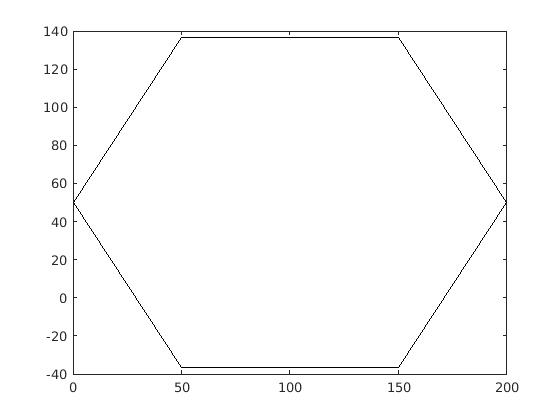

In [2]:
fDrawSector(100,100+50*i)

**Passo 03:** Crie uma função chamada **fDrawDeploy.m** com o seguinte código. Ela servirá para desenhar o grid celular. Tal função servirá para termos certeza que o posicionamento das ERBs estão corretos.

In [3]:
%%file fDrawDeploy.m
function fDrawDeploy(dR,vtBs)
% Desenha setores hexagonais
hold on;
for iBsD = 1 : length(vtBs)
    fDrawSector(dR,vtBs(iBsD));
end
% Plot BSs
plot(vtBs,'sk'); axis equal;
end

Created file '/home/labsim/EEC1714/fDrawDeploy.m'.


**Passo 04:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_P1_1.m**). Nesse código, vamos criar um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.

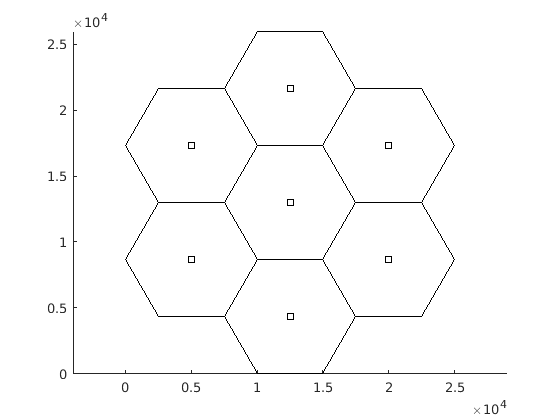

In [4]:
dR = 5e3; % Raio do Hexágono
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)

% Desenha setores hexagonais
fDrawDeploy(dR,vtBs)
axis equal;

## Prática 02: Criação dos pontos de medição

Vamos escrever um código para criação dos pontos de medição do REM de cada ERB. A ideia é criar 7 matrizes, cada uma com a posição relativa dos pontos de medição de todo o grid para cada ERB. Assim, teremos uma matriz de pontos de medição para cada ERB, nas quais o ponto (0,0) é centralizado em cada ERB respectiva. Essas matrizes serão armazenadas em uma matriz 3D denomida **mtPosEachBS**. Cada elemento da matriz (pocisionamento de cada ponto de medição) é modelado como um número complexo X + jY, sendo X a posição na abscissa e, Y a posição no eixo das ordenadas.

**Passo 01:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_P21.m**). Nesse código, vamos criar:

- Um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.
- Criação da matriz 3D **mtPosEachBS** com as matrizes de pontos de medição de cada ERB, nas quais o ponto (0,0) é centralizado em cada ERB respectiva. 
- Plot das posições relativas dos pontos de medição de cada ERB.

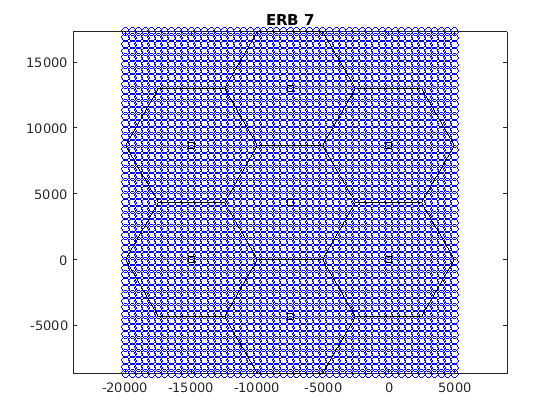

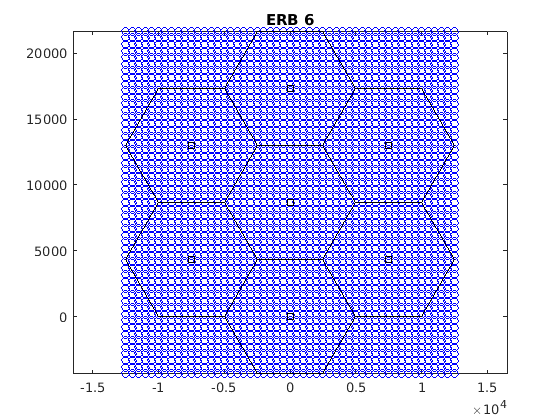

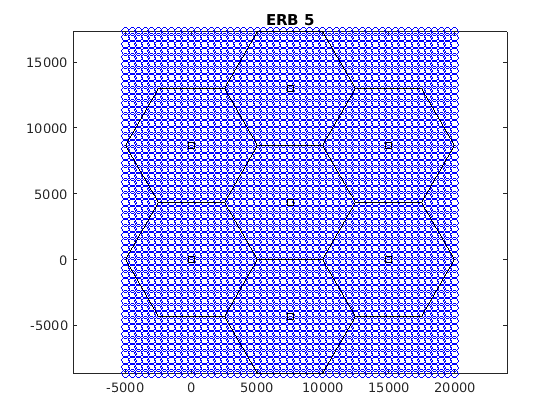

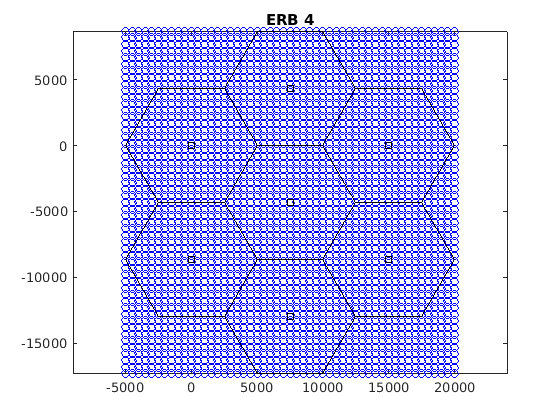

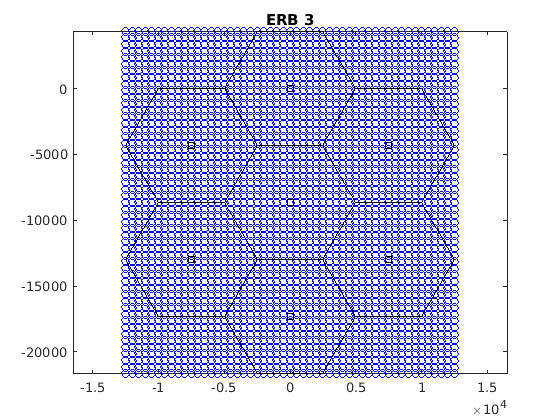

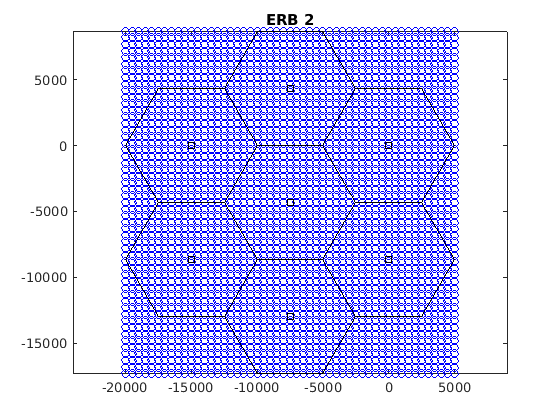

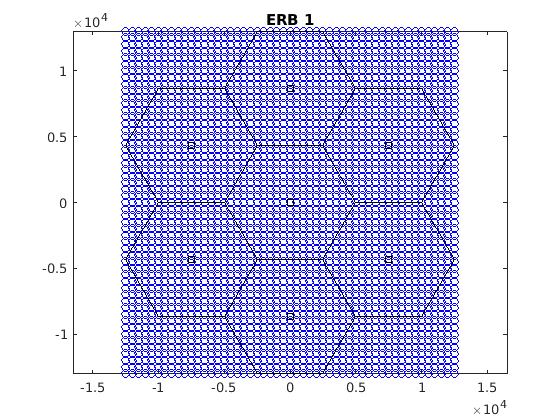

In [5]:
clear all;clc;close all;                                   % Limpa variáveis, limpa tela e fecha todas as figuras

% Entrada de parâmetros
dR = 5e3; % Raio do Hexágono
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dPasso = ceil(dR/10);                                      % Resolução do grid: distância entre pontos de medição
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = dDimY+mod(dDimY,dPasso);                           % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = dDimX+mod(dDimX,dPasso);                           % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
%
% Calcular os pontos de medição relativos de cada ERB
for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
    % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
    % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
    mtPosEachBS(:,:,iBsD)=(mtPosx + j*mtPosy)-(vtBs(iBsD));
    % Plot da posição relativa dos pontos de medição de cada ERB individualmente
    figure;
    plot(mtPosEachBS(:,:,iBsD),'bo');
    hold on;
    fDrawDeploy(dR,vtBs-vtBs(iBsD))
    axis equal;
    title(['ERB ' num2str(iBsD)]);
end

**A execução do código resulta em:**
1. Sete gráficos mostrando o grid celular e os pontos de medição **relativos** a cada ERB. 
2. A ERB está identificada no título de cada gráfico;
3. Note que o ponto (0,0) de cada ERB (de cada gráfico), i.e. seu posicionamento, é diferente. Na ERB 1, o ponto (0,0) está no centro (posição da ERB 1) e, na ERB 6, o ponto (0,0) está no centro do hexágono inferior, posição central da ERB. 

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

## Prática 03: Cálculo e plot da potência recebida 

Vamos escrever um código para o cálculo da potência recebida nos pontos de medição do REM de cada ERB, e também considerando a composição das 7 ERBs. Como especificado no hands-on, precisamos considerar que a potência recebida de cada ponto de medição é a maior potência recebida em relação as 7 ERBs.

**Passo 01:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_p31.m**). Nesse código, vamos:

- Criar sete matrizes de distâncias relativas de cada ponto de medição e para cada ERB (matrizes **mtDistEachBs**). Aplicaremos o raio de segurança a essas distâncias;
- Com as distâncias, usaremos o modelo de Okumura-Hata para calcular a perda de percurso (matrizes **mtPldB**);
- Com a EIRP e a perda de percurso, calcularemos a potência recebida de cada ERB em cada ponto de medição. Para cada ERB montaremos a matriz **mtPowerEachBSdBm**;
- Montaremos uma única matriz **mtPowerFinaldBm** com a maior potência recebida em cada ponto de medição;
- Plotaremos o REM de cada ERB e da composição das 7 ERBs.



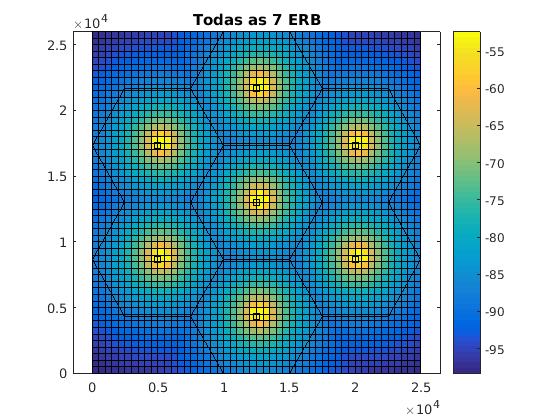

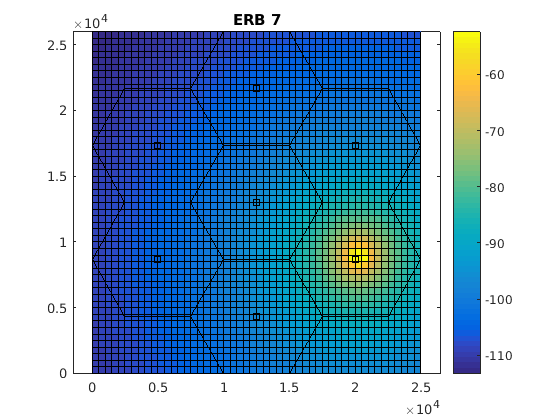

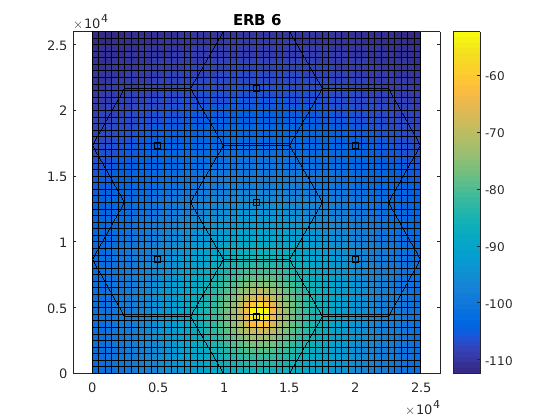

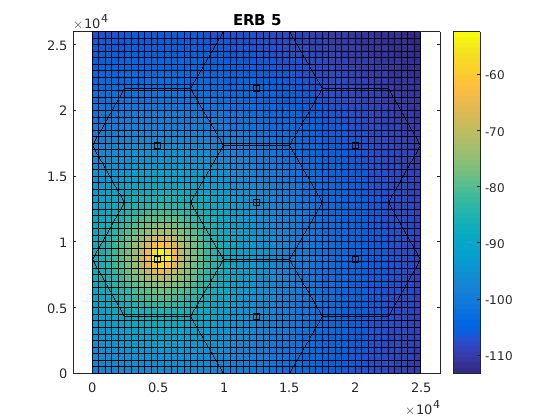

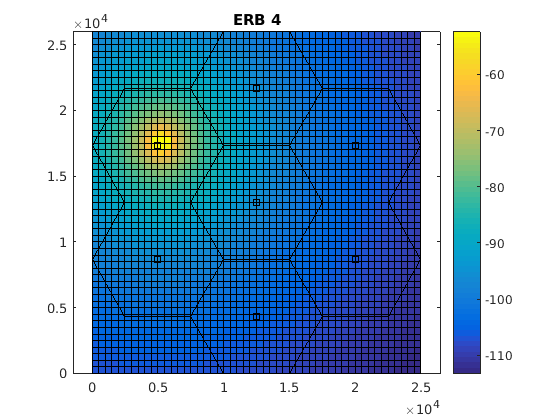

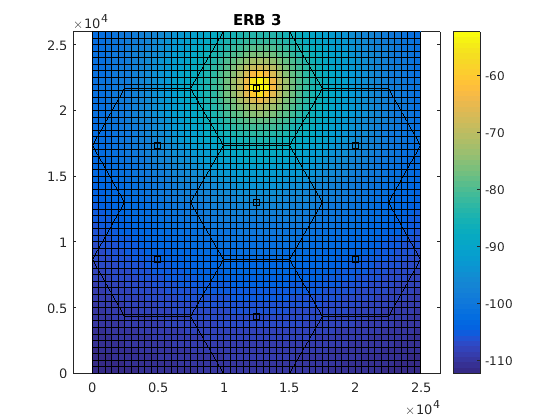

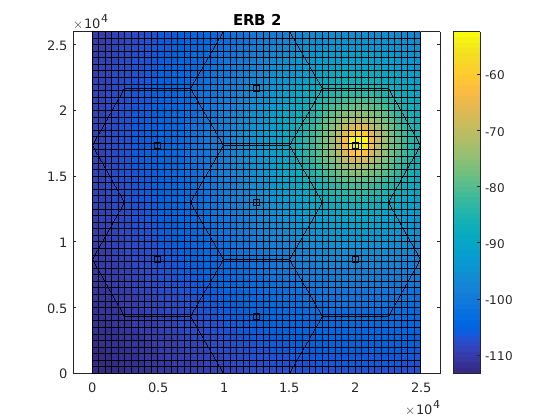

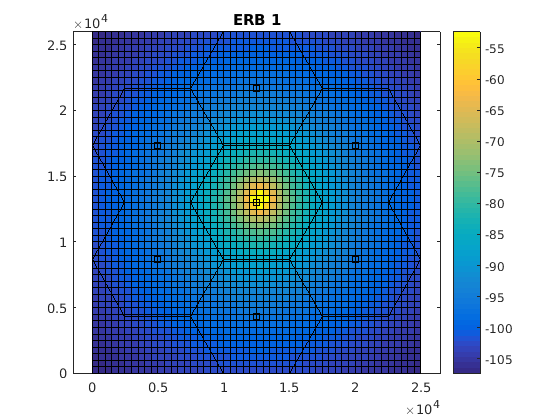

In [1]:
% Entrada de parâmetros
dR = 5e3;  % Raio do Hexágono
dFc = 800; % Frequência da portadora MHz
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dPasso = ceil(dR/10);                                      % Resolução do grid: distância entre pontos de medição
dRMin = dPasso;                                            % Raio de segurança
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
dPtdBm = 57;                                               % EIRP (incluindo ganho e perdas) (https://pt.slideshare.net/naveenjakhar12/gsm-link-budget)
dPtLinear = 10^(dPtdBm/10)*1e-3;                           % EIRP em escala linear
dHMob = 5;                                                 % Altura do receptor
dHBs = 30;                                                 % Altura do transmissor
dAhm = 3.2*(log10(11.75*dHMob)).^2 - 4.97;                 % Modelo Okumura-Hata: Cidade grande e fc  >= 400MHz
%
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = dDimY+mod(dDimY,dPasso);                           % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = dDimX+mod(dDimX,dPasso);                           % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
%
% Iniciação da Matriz de  pontência recebida máxima em cada ponto
% medido. Essa potência é a maior entre as 7 ERBs.
mtPowerFinaldBm = -inf*ones(size(mtPosy));
% Calcular O REM de cada ERB e aculumar a maior potência em cada ponto de medição
for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
    % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
    % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
    mtPosEachBS(:,:,iBsD)=(mtPosx + j*mtPosy)-(vtBs(iBsD));
    mtDistEachBs = abs(mtPosEachBS(:,:,iBsD));              % Distância entre cada ponto de medição e a sua ERB
    mtDistEachBs(mtDistEachBs < dRMin) = dRMin;             % Implementação do raio de segurança
    % Okumura-Hata (cidade urbana) - dB
    mtPldB = 69.55 + 26.16*log10(dFc) + (44.9 - 6.55*log10(dHBs))*log10(mtDistEachBs/1e3) - 13.82*log10(dHBs) - dAhm;
    mtPowerEachBSdBm(:,:,iBsD) = dPtdBm - mtPldB;           % Potências recebidas em cada ponto de medição
    % Plot da REM de cada ERB individualmente
    figure;
    pcolor(mtPosx,mtPosy,mtPowerEachBSdBm(:,:,iBsD));
    colorbar;
    % Desenha setores hexagonais
    fDrawDeploy(dR,vtBs)
    axis equal;
    title(['ERB ' num2str(iBsD)]);
    % Cálulo da maior potência em cada ponto de medição
    mtPowerFinaldBm = max(mtPowerFinaldBm,mtPowerEachBSdBm(:,:,iBsD));
end
% Plot da REM de todo o grid (composição das 7 ERBs)
figure;
pcolor(mtPosx,mtPosy,mtPowerFinaldBm);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB']);

## Prática 04: Cálculo da Outage de Potência 

Vamos escrever um código para a taxa de outage de potência, i.e., a porcentagem de pontos que estão com potência abaixo da sensibilidade do receptor. 

**Passo 01:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson1_p41.m**). Nesse código, vamos:

- Exluir todos os plots;
- Definir a sensibilidade do receptor (dSensitivity = -104);
- Aumentar a resolução do grid, i.e., o número de pontos de medição (dPasso = dR/50);

In [7]:
vtFc = [800 900 1800 1900 2100];
for iFc = 1:length(vtFc)
    dFc = vtFc(iFc);
    % Entrada de parâmetros
    dR = 10e3; % Raio do Hexágono
    % Cálculos de outras variáveis que dependem dos parâmetros de entrada
    dPasso = ceil(dR/50);                                     % Resolução do grid: distância entre pontos de medição
    dRMin = dPasso;                                            % Raio de segurança
    dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
    dDimX = 5*dR;                                              % Dimensão X do grid
    dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
    dPtdBm = 57;                                               % EIRP (incluindo ganho e perdas) (https://pt.slideshare.net/naveenjakhar12/gsm-link-budget)
    dPtLinear = 10^(dPtdBm/10)*1e-3;                           % EIRP em escala linear
    dSensitivity = -104;                                       % Sensibilidade do receptor (http://www.comlab.hut.fi/opetus/260/1v153.pdf)
    dHMob = 5;                                                 % Altura do receptor
    dHBs = 30;                                                 % Altura do transmissor
    dAhm = 3.2*(log10(11.75*dHMob)).^2 - 4.97;                 % Modelo Okumura-Hata: Cidade grande e fc  >= 400MHz
    %
    % Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
    vtBs = [ 0 ];
    dOffset = pi/6;
    for iBs = 2 : 7
        vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
    end
    vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
    %
    % Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
    dDimY = ceil(dDimY+mod(dDimY,dPasso));                     % Ajuste de dimensão para medir toda a dimensão do grid
    dDimX = ceil(dDimX+mod(dDimX,dPasso));                     % Ajuste de dimensão para medir toda a dimensão do grid
    [mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
    %
    % Iniciação da Matriz de com a pontência de recebida máxima em cada ponto
    % medido. Essa potência é a maior entre as 7 ERBs.
    mtPowerFinaldBm = -inf*ones(size(mtPosy));
    % Calcular O REM de cada ERB e aculumar a maior potência em cada ponto de medição
    for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
        % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
        % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
        mtPosEachBS =(mtPosx + j*mtPosy)-(vtBs(iBsD));
        mtDistEachBs = abs(mtPosEachBS);              % Distância entre cada ponto de medição e a sua ERB
        mtDistEachBs(mtDistEachBs < dRMin) = dRMin;             % Implementação do raio de segurança
        % Okumura-Hata (cidade urbana) - dB
        mtPldB = 69.55 + 26.16*log10(dFc) + (44.9 - 6.55*log10(dHBs))*log10(mtDistEachBs/1e3) - 13.82*log10(dHBs) - dAhm;
        mtPowerEachBSdBm = dPtdBm - mtPldB;           % Potências recebidas em cada ponto de medição
        % Cálulo da maior potência em cada ponto de medição
        mtPowerFinaldBm = max(mtPowerFinaldBm,mtPowerEachBSdBm);
    end
    %
    % Outage (limite 10%)
    dOutRate = 100*length(find(mtPowerFinaldBm < dSensitivity))/numel(mtPowerFinaldBm);
    disp(['Frequência da portadora = ' num2str(dFc)]);
    disp(['Taxa de outage = ' num2str(dOutRate) ' %']);
end

Frequência da portadora = 800
Taxa de outage = 7.5193 %
Frequência da portadora = 900
Taxa de outage = 10.8043 %
Frequência da portadora = 1800
Taxa de outage = 46.7555 %
Frequência da portadora = 1900
Taxa de outage = 50.8006 %
Frequência da portadora = 2100
Taxa de outage = 57.6315 %


## Prática 05: Cálculo da Outage de SINR

Além da potência mínima de operação, a SINR é um fator de suma importância para garantir a Qualidade de Serviço (QoS) do sistema. Se o usuário estiver com SINR menor que uma mínima especificada, a Taxa de Erro de Bit (BER) é muito alta. Nessa situação, uma importante parcela do que é transmitido poderá ser perdido devido a BER alta.

   - Agora, faça o mapa de SINR ao invés da potência recebida. Suponha que as estações base estão transmitindo em uma mesma frequência e por todo tempo (similar a um sistema com reuso 1).
   - Assumindo que a outage de SINR (taxa de bloqueio ou interrupção por SINR) ocorre quando a conexão experimenta uma SINR menor que uma SINR mínima, faça um gráfico com a outage por SINR quando a SINR mínima for 1 dB (precisamos definir melhor esse valor. Tanto de potência transmistida quanto de SINR mínima);
   - Use sua potência igual a -106,98 dBm;
   - Para evitar efeitos de baixa interferência nas células das bordas, analise a outage somente dos pontos com potência recebida da célula central;
   - Talvez não precise disso porque não estamos usando shadowing (mas deixei anotado para a gente discutir): para que o experimento tenha confiabilidade estatística, a contagem de outage deve ser feita para mais de um experimento (sugestão 100-1000 experimentos);
   - É interessante bolarmos uma situação em que não se tenha outage de potência, mas tenha outage de SINR (talvez com raio pequeno). Vamos usar o código para bolar entregas para os alunos explorarem esses conceitos.